In [ ]:
# taking input file

from google.colab import drive
drive.mount('/content/drive/')

In [2]:
# this dataset is already preprocessed

import pandas as pd
df = pd.read_csv('/content/drive/My Drive/edited_topics_set2.csv')

In [ ]:
#df.head()

In [3]:
# to count words
df['body_word_count'] = df['processed_content'].apply(lambda x: len(x.strip().split()))  # word count in abstract

df['body_unique_words']=df['processed_content'].apply(lambda x:len(set(str(x).split())))  # number of unique words in body
df.head()

,Unnamed: 0,Unnamed: 0.1,_id,topic,content,processed_content,processed_topic,body_word_count,body_unique_words
0,0,0,5f04e496ef217aae6a201f71,"[""National""]","[""The West Bengal government on Tuesday decide...",west bengal govern tuesday decid impos complet...,nation,215,110
1,1,1,5f04e498ef217aae6a201f72,"[""Business""]","[""The government is weighing the pros and cons...",govern weigh pros con halt import includ china...,busi,140,109
2,2,2,5f04e49aef217aae6a201f73,"[""National""]","[""The Central Board of Secondary Education (CB...",central board secondari educ cbse slash syllab...,nation,143,110
3,3,3,5f04e49def217aae6a201f74,"[""International""]","[""The World Health Organization on Tuesday ack...",world health organ tuesday acknowledg emerg ev...,intern,35,32
4,4,4,5f04e49fef217aae6a201f75,"[""International""]","[""President Donald Trump on Tuesday formally s...",presid donald trump tuesday formal start withd...,intern,320,203


In [ ]:
#df.to_csv('/content/drive/My Drive/all_news_with_count.csv')

In [ ]:
#df.describe()

In [20]:
#vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

In [28]:
# vectorizing processed content

text = df['processed_content'].values
X = vectorize(text, 2 ** 12)
X.shape

(2155, 4096)

In [22]:
#vectorizing processed topic
topics = df['processed_topic'].values
X_topic = vectorize(topics, 2 ** 12)
X_topic.shape

(2155, 57)

PCA & Clustering
Let's see how much we can reduce the dimensions while still keeping 95% variance. We will apply Principle Component Analysis (PCA) to our vectorized data. The reason for this is that by keeping a large number of dimensions with PCA, you don’t destroy much of the information, but hopefully will remove some noise/outliers from the data, and make the clustering problem easier for k-means. Note that X_reduced will only be used for k-means, t-SNE will still use the original feature vector X that was generated through tf-idf on the NLP processed text.

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(2155, 1224)

To separate the literature, k-means will be run on the vectorized text. Given the number of clusters, k, k-means will categorize each vector by taking the mean distance to a randomly initialized centroid. The centroids are updated iteratively.

In [ ]:
from sklearn.cluster import KMeans

How many clusters?
To find the best k value for k-means we'll look at the distortion at different k values. Distortion computes the sum of squared distances from each point to its assigned center. When distortion is plotted against k there will be a k value after which decreases in distortion are minimal. This is the desired number of clusters

In [ ]:
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np

# run kmeans with many different k
distortions = []
K = range(28, 30)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    print('Found distortion for {} clusters'.format(k))

Found distortion for 28 clusters
Found distortion for 29 clusters


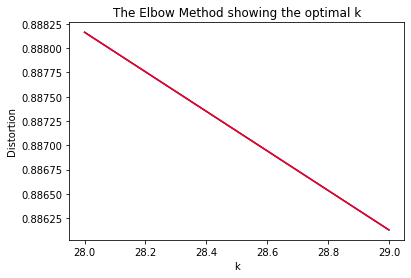

In [ ]:
import matplotlib.pyplot as plt

X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
k = 30 #taking 30 clusters
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df['y'] = y_pred ##storing the corresponding clusters of each row

In [ ]:
# to convert the topics to numeric array using pandas
topics_num = pd.factorize(df.topic)[0]
topics_num

array([ 0,  1,  0, ..., 59,  1,  1])

Dimensionality Reduction with t-SNE
Using t-SNE we can reduce our high dimensional features vector to 2 dimensions. By using the 2 dimensions as x,y coordinates, the body_text can be plotted.

t-Distributed Stochastic Neighbor Embedding (t-SNE) reduces dimensionality while trying to keep similar instances close and dissimilar instances apart. It is mostly used for visualization, in particular to visualize clusters of instances in high-dimensional space

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 2155 samples in 1.278s...
[t-SNE] Computed neighbors for 2155 samples in 46.539s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2155
[t-SNE] Computed conditional probabilities for sample 2000 / 2155
[t-SNE] Computed conditional probabilities for sample 2155 / 2155
[t-SNE] Mean sigma: 0.380305
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.399277
[t-SNE] KL divergence after 1000 iterations: 1.226522


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


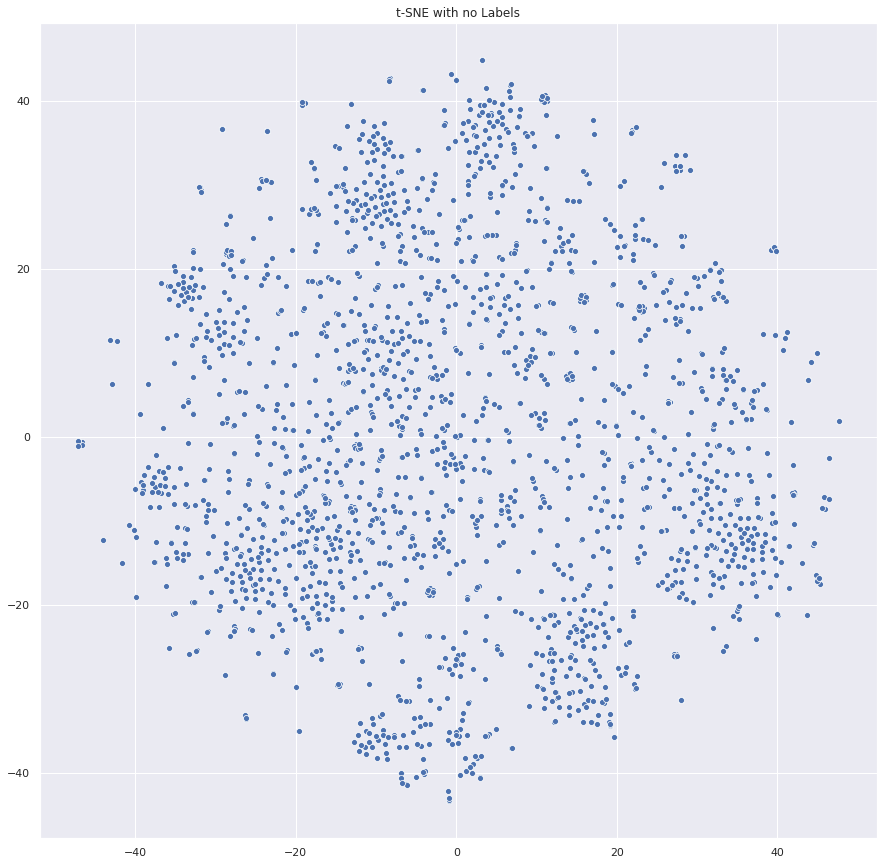

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig("t-sne_covid19.png")
plt.show()

This looks pretty bland. There are some clusters we can immediately detect, but the many instances closer to the center are harder to separate. t-SNE did a good job at reducing the dimensionality, but now we need some labels. Let's use the clusters found by k-means as labels. This will help visually separate different concentrations of topics.

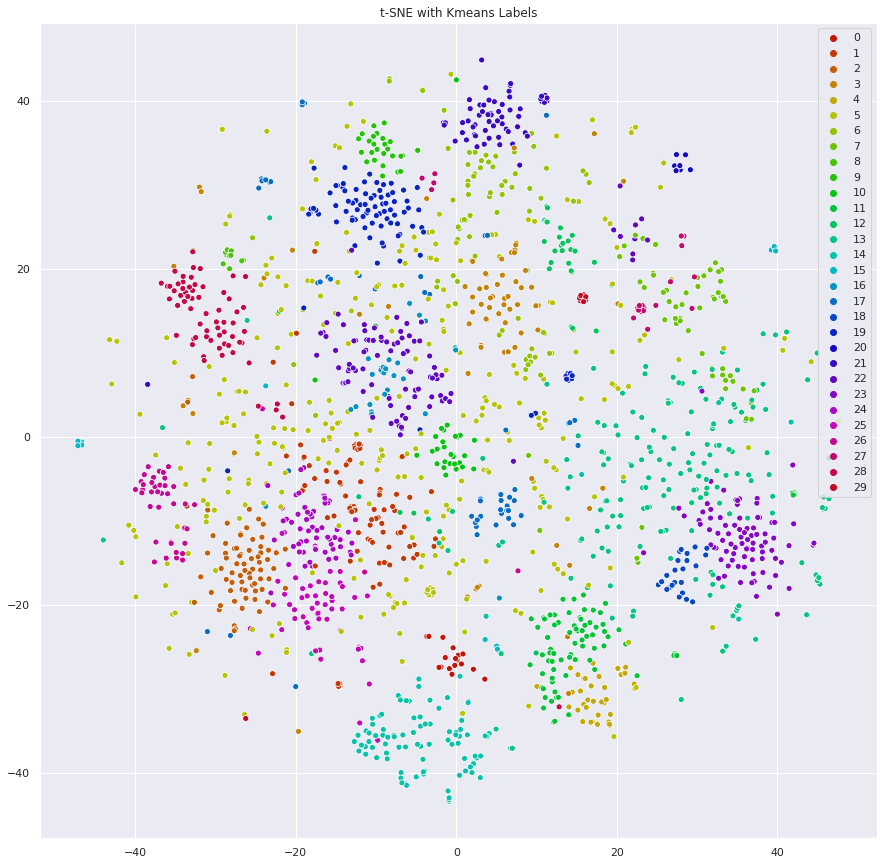

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(30, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

In [ ]:
#clustering result

In [ ]:
df['y'].value_counts()

5     376
13    226
22    105
14     98
1      96
19     95
3      95
23     93
11     85
6      83
2      78
28     73
21     70
7      67
24     64
17     58
25     57
26     48
4      39
12     34
10     33
16     30
9      29
18     27
27     25
0      22
15     18
8      11
20     11
29      9
Name: y, dtype: int64

Original topics

There are 52 news categories


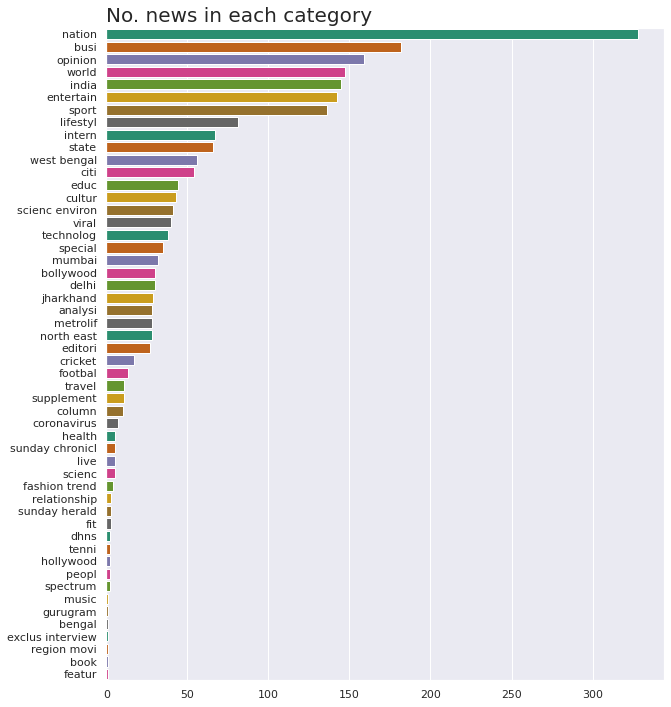

In [ ]:
#No. of contents in each category
count_df = pd.DataFrame(df['processed_topic'].value_counts()).reset_index()
print('There are', len(count_df), 'news categories')

sns.set_style('darkgrid')
plt.figure(figsize=(10, 12))
sns.barplot(data=count_df, y='index', x='processed_topic', palette='Dark2')
plt.title('No. news in each category', loc='left', fontsize=20)
plt.xlabel("")
plt.ylabel("")
plt.show()

After clustering with 30 clusters

There are 30 news categories


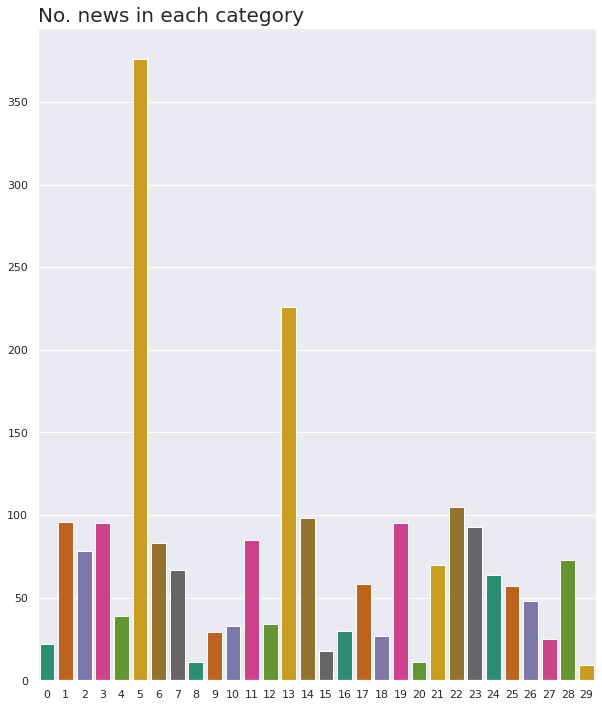

In [ ]:
#No. of contents in each category
count_df = pd.DataFrame(df['y'].value_counts()).reset_index()
print('There are', len(count_df), 'news categories')

sns.set_style('darkgrid')
plt.figure(figsize=(10, 12))
sns.barplot(data=count_df, y='y', x='index', palette='Dark2')
plt.title('No. news in each category', loc='left', fontsize=20)
plt.xlabel("")
plt.ylabel("")
plt.show()

In [ ]:
#df[df.y == 17]

Topic Modeling on Each Cluster
Now we will attempt to find the most significant words in each clusters. K-means clustered the articles but did not label the topics. Through topic modeling we will find out what the most important terms for each cluster are. This will add more meaning to the cluster by giving keywords to quickly identify the themes of the cluster.

For topic modeling, we will use LDA (Latent Dirichlet Allocation). In LDA, each document can be described by a distribution of topics and each topic can be described by a distribution of words.

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
#First we will create 20 vectorizers, one for each of our cluster labels

vectorizers = []
    
for ii in range(0, 30):
 #   Creating a vectorizer
   vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

In [ ]:
vectorizers[0]

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.9, max_features=None, min_df=5,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='[a-zA-Z\\-][a-zA-Z\\-]{2,}',
                tokenizer=None, vocabulary=None)

In [ ]:
#Now we will vectorize the data from each of our clusters

vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
   try:
       vectorized_data.append(cvec.fit_transform(df.loc[df['y'] == current_cluster, 'processed_content']))
   except Exception as e:
       print("Not enough instances in cluster: " + str(current_cluster))
       vectorized_data.append(None)
len(vectorized_data)

30

In [ ]:
 #number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 20

lda_models = []
for ii in range(0, 30):
    #Latent Dirichlet Allocation Model
   lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
   lda_models.append(lda)
    
lda_models[0]

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=False)

In [ ]:
#For each cluster, we had created a correspoding LDA model in the previous step. We will now fit_transform all the LDA models on their respective cluster vectors

clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))
        
#Extracts the keywords from each cluster

# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [ ]:
#Append list of keywords for a single cluster to 2D list of length NUM_TOPICS_PER_CLUSTER

all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))
all_keywords[3][:10]

['govern',
 'jadhav',
 'pakistan',
 'india',
 'templ',
 'famili',
 'tribun',
 'bench',
 'women',
 'say']

In [ ]:
#lda

for i in range(0,30):
  print(all_keywords[i][:10])

['game', 'world', 'time', 'feder', 'shooter', 'athlet', 'agenc', 'train', 'indian', 'dope']
['countri', 'coronavirus', 'state', 'bolsonaro', 'polic', 'famili', 'local', 'diseas', 'campaign', 'maharashtra']
['ambul', 'order', 'monitor', 'level', 'work', 'minist', 'charg', 'duti', 'govern', 'polic']
['govern', 'jadhav', 'pakistan', 'india', 'templ', 'famili', 'tribun', 'bench', 'women', 'say']
['result', 'exam', 'reduc', 'start', 'say', 'univers', 'examin', 'minist', 'final', 'syllabus']
['india', 'covid', 'minist', 'immun', 'peopl', 'say', 'mar', 'food', 'year', 'villag']
['bengal', 'kashmir', 'pakistan', 'cabinet', 'opposit', 'ayodhya', 'erdogan', 'lord', 'turkey', 'allow']
['share', 'say', 'twitter', 'relianc', 'amazon', 'galaxi', 'devic', 'compani', 'phone', 'podcast']
['attack', 'wife', 'encount', 'morn', 'hous', 'crpf', 'fight', 'local', 'thursday', 'happen']
['area', 'indian', 'line', 'ladakh', 'time', 'oper', 'border', 'chines', 'say', 'armi']
['airport', 'passeng', 'india', 'ope

Classification Report - Taking tf-idf matrix of content (X) as ground truth

For 30 clusters

In [ ]:
# function to print out classification model report
def classification_report(model_name, test, pred):
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='macro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='macro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='macro')) * 100), "%")
    
#Let's split the data into train/test sets

from sklearn.model_selection import train_test_split

# test set size of 20% of the data and the random seed 42 <3
X_train, X_test, y_train, y_test = train_test_split(X.toarray(),y_pred, test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

X_train size: 1724
X_test size: 431 



Precision is ratio of True Positives to True Positives + False Positives. This is the accuracy of positive predictions
Recall (also known as TPR) measures the ratio of True Positives to True Positives + False Negatives. It measures the ratio of positive instances that are correctly detected by the classifer.
F1 score is the harmonic average of the precision and recall. F1 score will only be high if both precision and recall are high

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier

# SGD instance
sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3, random_state=42, n_jobs=4)
# train SGD
sgd_clf.fit(X_train, y_train)

# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=4)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_train, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  85.325 %
     Precision:  88.814 %
        Recall:  85.205 %
      F1 score:  86.521 %


Classification Report - Taking tf-idf matrix of topic as ground truth

For 30 clusters

In [ ]:
# function to print out classification model report
def classification_report(model_name, test, pred):
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='macro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='macro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='macro')) * 100), "%")
    
#Let's split the data into train/test sets

from sklearn.model_selection import train_test_split

# test set size of 20% of the data and the random seed 42 <3
X_train, X_test, y_train, y_test = train_test_split(X_topic.toarray(),y_pred, test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

X_train size: 1724
X_test size: 431 



In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier

# SGD instance
sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3, random_state=42, n_jobs=4)
# train SGD
sgd_clf.fit(X_train, y_train)

# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=4)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_train, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  28.480 %
     Precision:  15.812 %
        Recall:  19.459 %
      F1 score:  15.661 %


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#df.to_csv('/content/drive/My Drive/k_means_clustered.csv')

In [ ]:
# from sklearn.metrics import normalized_mutual_info_score
# nmi = normalized_mutual_info_score(df.topic, y_pred)

Topic Modeling with nmf

This is independent topic modeling means not evaluating the topic of the clusters. It is topic modeling by using the tfidf vectors of content

independent topic modeling seems to work really well 

Topic Modeling without PCA (data without dimension reduction step before)

In [16]:
#for extracting features
n_topics = 30 #dividing into 30 topics
random_state = 0

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vec = TfidfVectorizer(max_features=5000, stop_words="english", max_df=0.95, min_df=2)
# vectorizing the processed_Content
features = vec.fit_transform(df.processed_content)

#vectorizing the processed_topic(only for testing purpose)
features_topics = vec.fit_transform(df.processed_topic)

#for topic modelling

from sklearn.decomposition import NMF
cls = NMF(n_components=n_topics, random_state=random_state)
cls.fit(features)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=30, random_state=0, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [5]:
# list of unique words found by the vectorizer

# top 15 words of each topic
feature_names = vec.get_feature_names()

# number of most influencing words to display per topic
n_top_words = 15

for i, topic_vec in enumerate(cls.components_):
    print(i, end=' ')
    for fid in topic_vec.argsort()[-1:-n_top_words-1:-1]:
        print(feature_names[fid], end=' ')
    print()

0 peopl mask virus health infect respons wear social pandem distanc world coronavirus diseas need possibl 
1 case death covid test number infect coronavirus posit state total report district talli juli rate 
2 china chines beij india hong kong countri pompeo militari consul communist trade foreign econom unit 
3 congress parti pilot gehlot rajasthan mlas leader gandhi sachin polit govern chief ashok minist assembl 
4 school student teacher educ class learn onlin children teach parent say univers govern institut colleg 
5 polic say arrest investig station accus alleg personnel case offic inspector murder tortur violenc regist 
6 cent crore bank quarter sector lakh profit fiscal year manufactur revenu econom consumpt june declin 
7 hospit patient covid test doctor treatment medic bed say health admit privat posit oxygen care 
8 test england cricket player team match leagu play indi game seri captain west tournament final 
9 app user mobil research devic data technolog privaci applic secu

Now predicting the topic number to which each article belong by the content of the article

In [6]:
cls.transform(vec.transform(df.processed_content)).argsort(axis=1)[:,-1]

array([ 1, 22,  4, ..., 15, 29,  6])

In [7]:
df['cluster_nmf'] = cls.transform(vec.transform(df.processed_content)).argsort(axis=1)[:,-1]

Storing the cluster number of each article in  cluster_nmf column

In [8]:
df.head()

,Unnamed: 0,Unnamed: 0.1,_id,topic,content,processed_content,processed_topic,body_word_count,body_unique_words,cluster_nmf
0,0,0,5f04e496ef217aae6a201f71,"[""National""]","[""The West Bengal government on Tuesday decide...",west bengal govern tuesday decid impos complet...,nation,215,110,1
1,1,1,5f04e498ef217aae6a201f72,"[""Business""]","[""The government is weighing the pros and cons...",govern weigh pros con halt import includ china...,busi,140,109,22
2,2,2,5f04e49aef217aae6a201f73,"[""National""]","[""The Central Board of Secondary Education (CB...",central board secondari educ cbse slash syllab...,nation,143,110,4
3,3,3,5f04e49def217aae6a201f74,"[""International""]","[""The World Health Organization on Tuesday ack...",world health organ tuesday acknowledg emerg ev...,intern,35,32,0
4,4,4,5f04e49fef217aae6a201f75,"[""International""]","[""President Donald Trump on Tuesday formally s...",presid donald trump tuesday formal start withd...,intern,320,203,13


In [12]:
#df.to_csv('/content/drive/My Drive/clustered_nmf_set2.csv')

Reducing the dimension for visualization

In [36]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state=42)
features_embedded = tsne.fit_transform(features.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 2155 samples in 1.013s...
[t-SNE] Computed neighbors for 2155 samples in 52.219s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2155
[t-SNE] Computed conditional probabilities for sample 2000 / 2155
[t-SNE] Computed conditional probabilities for sample 2155 / 2155
[t-SNE] Mean sigma: 0.376971
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.349091
[t-SNE] KL divergence after 1000 iterations: 1.212505


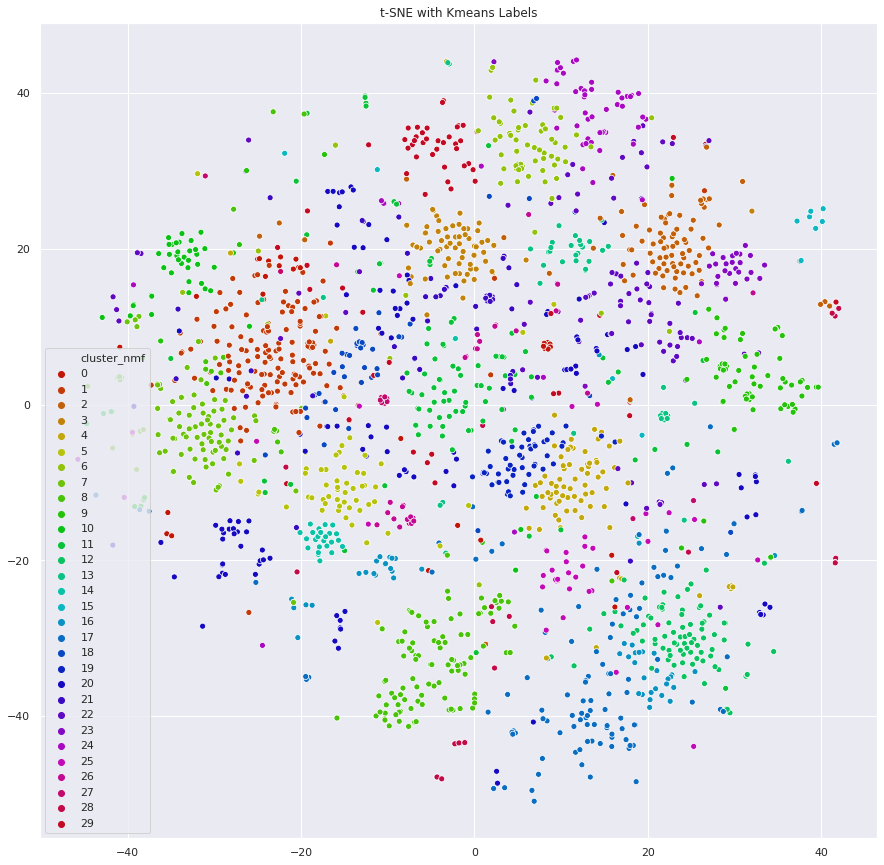

In [38]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(30, l=.4, s=.9)

# plot
sns.scatterplot(features_embedded[:,0], features_embedded[:,1], hue=df.cluster_nmf, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

Analysis

Actual Topics number

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


There are 52 news categories


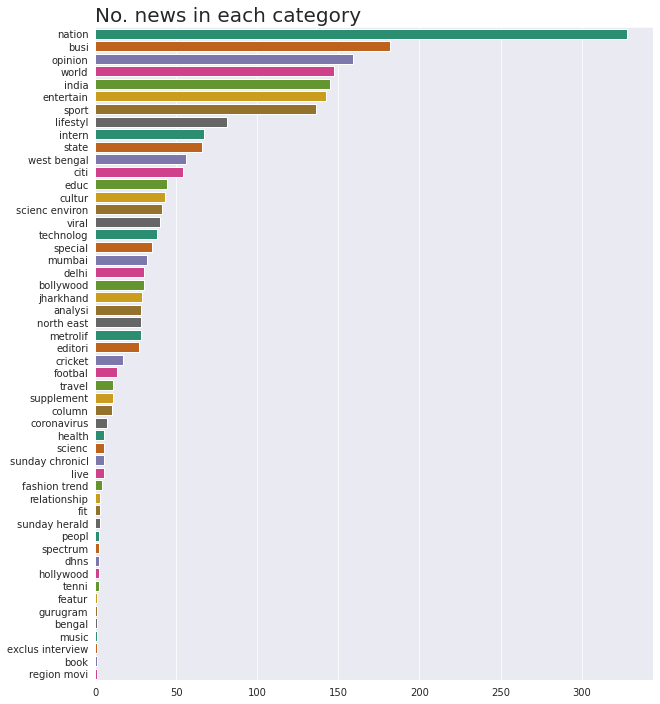

In [10]:
#No. of contents in each category
import seaborn as sns
import matplotlib.pyplot as plt

count_df = pd.DataFrame(df['processed_topic'].value_counts()).reset_index()
print('There are', len(count_df), 'news categories')

sns.set_style('darkgrid')
plt.figure(figsize=(10, 12))
sns.barplot(data=count_df, y='index', x='processed_topic', palette='Dark2')
plt.title('No. news in each category', loc='left', fontsize=20)
plt.xlabel("")
plt.ylabel("")
plt.show()

After topic modeling

There are 30 news categories


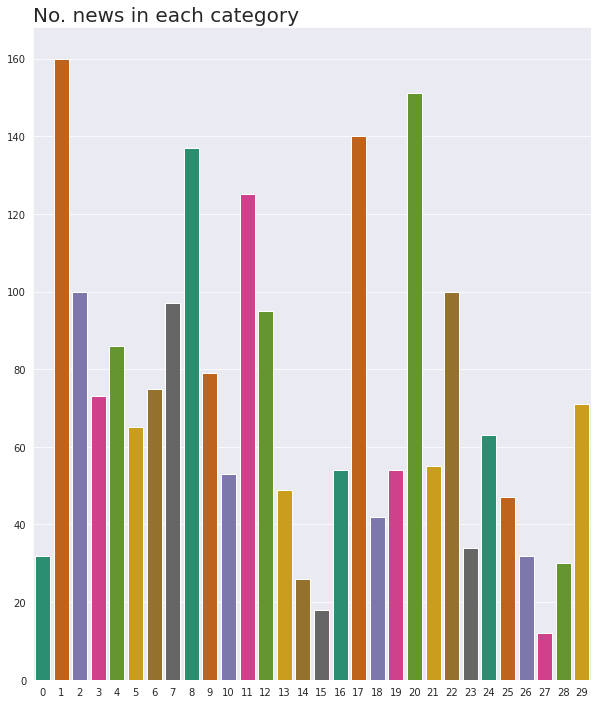

In [11]:
#No. of contents in each category
count_df = pd.DataFrame(df['cluster_nmf'].value_counts()).reset_index()
print('There are', len(count_df), 'news categories')

sns.set_style('darkgrid')
plt.figure(figsize=(10, 12))
sns.barplot(data=count_df, y='cluster_nmf', x='index', palette='Dark2')
plt.title('No. news in each category', loc='left', fontsize=20)
plt.xlabel("")
plt.ylabel("")
plt.show()

In [44]:
#df[df.cluster_nmf == 15]

Classification Report taking tf-idf matrix of content as ground truth

In [14]:
# function to print out classification model report
def classification_report(model_name, test, pred):
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='macro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='macro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='macro')) * 100), "%")
    
#Let's split the data into train/test sets

from sklearn.model_selection import train_test_split

# test set size of 20% of the data and the random seed 42 <3
X_train, X_test, y_train, y_test = train_test_split(features.toarray(),df.cluster_nmf, test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

X_train size: 1724
X_test size: 431 



In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier

# SGD instance
sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3, random_state=42, n_jobs=4)
# train SGD
sgd_clf.fit(X_train, y_train)

# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=4)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_train, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  81.206 %
     Precision:  83.685 %
        Recall:  77.373 %
      F1 score:  79.566 %


Classification Report taking tf-idf matrix of topic as ground truth

In [17]:
# function to print out classification model report
def classification_report(model_name, test, pred):
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='macro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='macro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='macro')) * 100), "%")
    
#Let's split the data into train/test sets

from sklearn.model_selection import train_test_split

# test set size of 20% of the data and the random seed 42 <3
X_train, X_test, y_train, y_test = train_test_split(features_topics.toarray(),df.cluster_nmf, test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

X_train size: 1724
X_test size: 431 



In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier

# SGD instance
sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3, random_state=42, n_jobs=4)
# train SGD
sgd_clf.fit(X_train, y_train)

# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=4)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_train, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  26.044 %
     Precision:  23.312 %
        Recall:  20.088 %
      F1 score:  18.424 %


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


END

Results - 

1. NMF has less accuracy score than PCA+Kmeans for both content and topic as ground truth.

2. NMF has better precision, recall and F1 score with topic as the ground truth but not for content as ground truth

3. Advantage - NMF is one step where as PCA+Kmeans is 2 step process.